In [32]:
import csv
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [33]:
totaliteration = 10000
printiteration = totaliteration//20
bins = 200 #dx = 1/bins; actual number of columns saved = bins-1, because 1st and last are 0
npots = 700 #ends up being 3*this*(validnth-1)/validnth
total_size = bins-1

In [34]:
###판다스를 이용한 데이터 로드
'''포텐셜 제네레이터에서 만든 위치를 로드'''
def datacsvLoad(labelParameterName, dataloadpath, labelloadpath):
    dataset = pd.read_csv(dataloadpath+".csv", index_col = 0)
    labelset = pd.read_csv(labelloadpath+".csv", index_col = 0)
    df_dataset = pd.DataFrame(np.transpose(dataset))
    df_labelset = pd.DataFrame(np.transpose(labelset))
    return [df_dataset, df_labelset]

load_dir = os.path.join(os.getcwd(), "potential_generator")
dataloadpath = os.path.join(load_dir, "Dataset")
labelloadpath = os.path.join(load_dir, "Label")
psi_v, listvofx = datacsvLoad(None, dataloadpath, labelloadpath)
psi_v, tfph_vofx_v = [np.array(psi_v), np.array(listvofx)]

In [35]:
'''로드한 자료가 올바른지 확인'''
print(psi_v1.shape)

(2100, 199)


In [36]:
'''트레이닝 셋으로 전체 갯수에서 100개를 제외하고 10개는 벨리데이션 셋으로 사용'''
train_set = 3*npots-100
deep_batch_size = 100

total_tra_poten = tfph_vofx_v[:train_set,:]
tra_poten = tf.placeholder(tf.float32, [None, bins-1])
val_poten = tfph_vofx_v[train_set:,:]
tra_psi = psi_v[:train_set,:]
val_psi = psi_v[train_set:,:]
tfph_BNbool = tf.placeholder(tf.bool)

print(val_poten.shape)

(100, 199)


In [37]:
'''히든레이어의 크기를 인풋과 아웃풋과 다르게 개미허리처럼 만들어봤다.
이렇게 하는 이유는 좀더 논리니어 한 결과가 나오기를 기대해서 이다.'''
Xdim_1 = 50
Xdim_2 = 50
deep_total_iteration = 100000
deep_printiteration = 1000

In [38]:
'''fully connected neural network
인풋으로 만들어 놓은 프사이를 넣어준다.
액티베이션 함수로는 가장 많이 사용하고 있는 소프트 플러스 함수를 사용했다.
이 함수의 논리니어 한 부분은 0에서 가장 크기 때문에 배치노말라이제이션을 해줬다.
즉, 웨이트와 바이어스의 가장 지배적인 값들이 0부분에 집중되어 있다.
코스트를 결과와 정답의 차의 제곱으로 잡고 미니마이즈.'''
initializer = tf.contrib.layers.xavier_initializer()

X_input = tf.placeholder(tf.float32, [None, bins-1])

weight_1 = tf.Variable(initializer([bins-1,Xdim_1]), dtype = tf.float32)
bias_1 = tf.Variable(initializer([Xdim_1]), dtype = tf.float32)
L1 = tf.matmul(X_input, weight_1) + bias_1
L1 = tf.layers.batch_normalization(L1, training=tfph_BNbool)
L1 = tf.nn.softplus(L1)

weight_2 = tf.Variable(initializer([Xdim_1, Xdim_2]), dtype = tf.float32)
bias_2 = tf.Variable(initializer([Xdim_2]), dtype = tf.float32)
L2 = tf.matmul(L1, weight_2) + bias_2
L2 = tf.layers.batch_normalization(L2, training=tfph_BNbool)
L2 = tf.nn.softplus(L2)

weight_3 = tf.Variable(initializer([Xdim_2, bins-1]), dtype = tf.float32)
bias_3 = tf.Variable(initializer([bins-1]), dtype = tf.float32)
result_poten = tf.nn.softplus(tf.matmul(L2, weight_3) + bias_3)

deep_cost = tf.reduce_mean(tf.square(tf.subtract(result_poten,tra_poten)))

In [39]:
'''배치노말라이제이션을 의해 필요한 부분'''
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):    
    deep_train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(deep_cost)

In [40]:
init = tf.global_variables_initializer()
# If you want to use CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

# sess = tf.Session(config=config)

# If you want to use GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

sess.run(init)

In [41]:
prevtime = datetime.now()
for i in range(deep_total_iteration):   
    sess.run(deep_train, feed_dict={X_input:tra_psi, tra_poten:total_tra_poten, tfph_BNbool:True})
    if i%deep_printiteration==0:
        deep_cost_v = sess.run(deep_cost, feed_dict={X_input:tra_psi, tra_poten:total_tra_poten, tfph_BNbool:True}) 
        deep_cost_v_valid = sess.run(deep_cost, feed_dict={X_input:val_psi, tra_poten:val_poten, tfph_BNbool:False})
        nowtime = datetime.now()
        print(str((100.*i)/deep_total_iteration) + '% complete')
        print('TakenTime: %s' % (str(nowtime-prevtime)))        
        print('training_cost: %f, test_cost: %f' % (deep_cost_v, deep_cost_v_valid))
print('Output complete')

0.0% complete
TakenTime: 0:00:00.235371
training_cost: 6937.083008, test_cost: 7247.973633
1.0% complete
TakenTime: 0:00:15.049790
training_cost: 2534.895996, test_cost: 3582.297607
2.0% complete
TakenTime: 0:00:36.212249
training_cost: 1854.008301, test_cost: 1984.786743
3.0% complete
TakenTime: 0:00:58.384010
training_cost: 1510.135498, test_cost: 1653.332397
4.0% complete
TakenTime: 0:01:19.926453
training_cost: 1302.486938, test_cost: 1508.196899
5.0% complete
TakenTime: 0:01:40.792702
training_cost: 1175.960205, test_cost: 1404.772949
6.0% complete
TakenTime: 0:02:02.335145
training_cost: 1075.632690, test_cost: 1333.320068
7.0% complete
TakenTime: 0:02:22.802461
training_cost: 1020.643433, test_cost: 1296.635620
8.0% complete
TakenTime: 0:02:42.782079
training_cost: 974.678284, test_cost: 1222.467163
9.0% complete
TakenTime: 0:03:02.528321
training_cost: 938.044434, test_cost: 1239.129761
10.0% complete
TakenTime: 0:03:21.967384
training_cost: 904.991699, test_cost: 1203.987793
1

(100, 199)


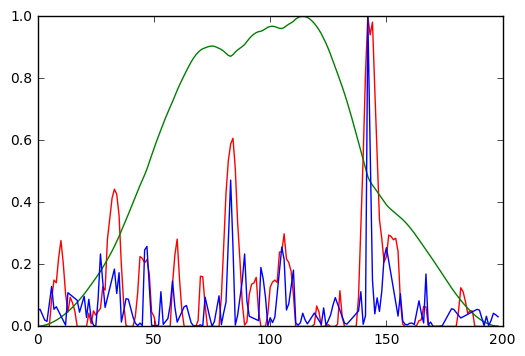

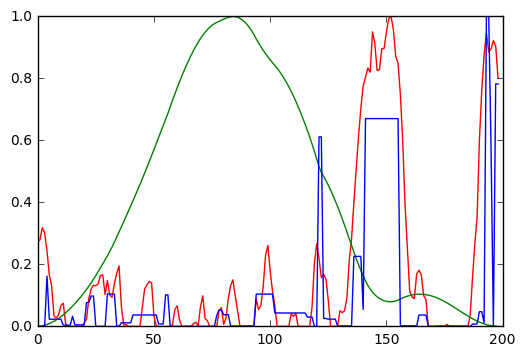

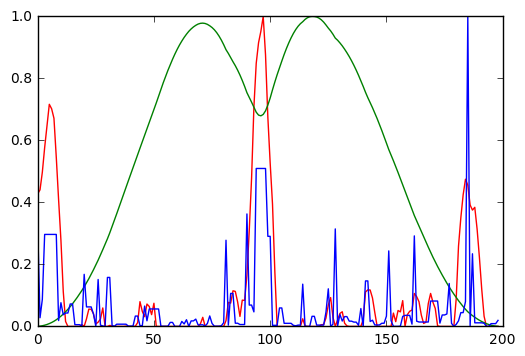

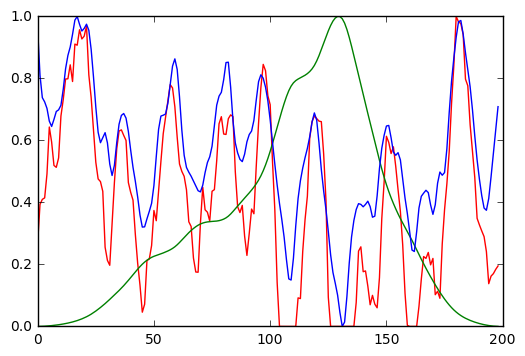

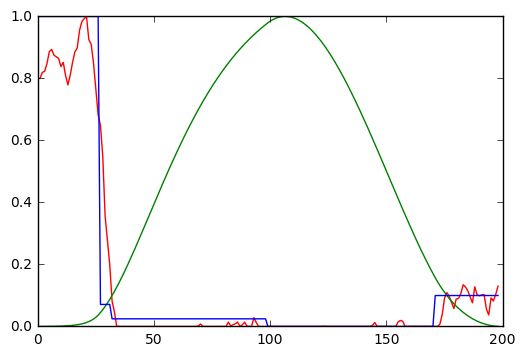

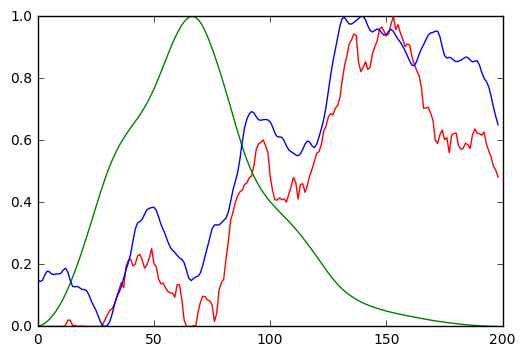

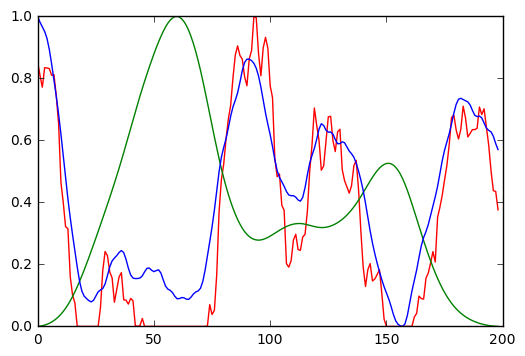

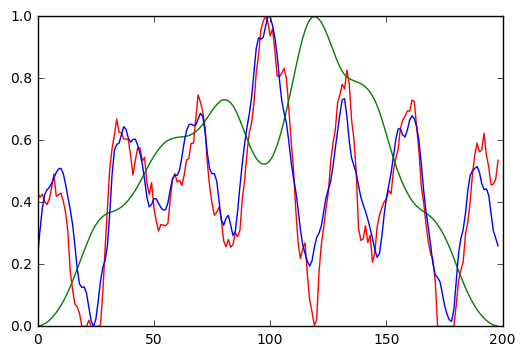

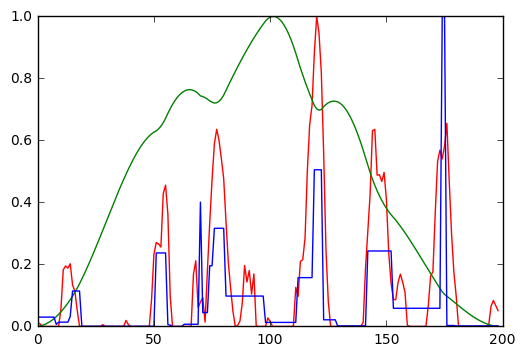

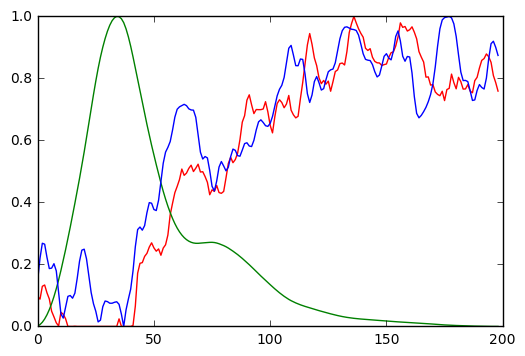

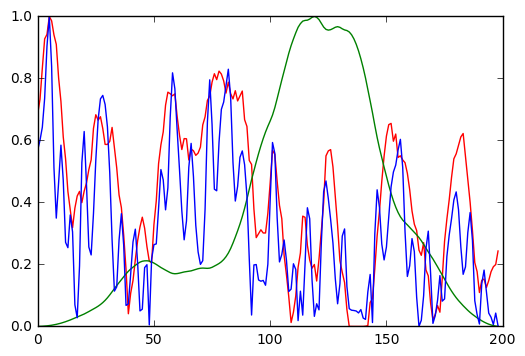

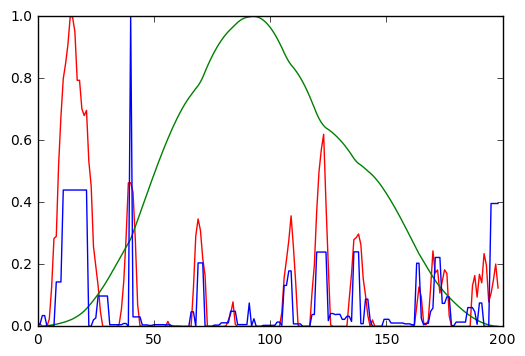

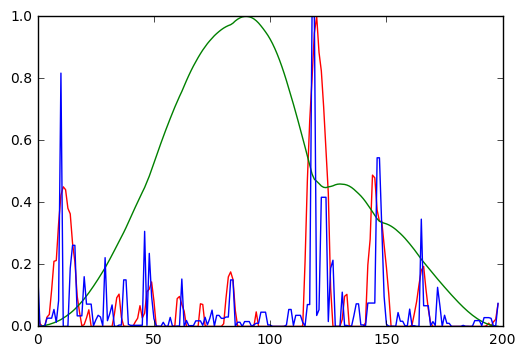

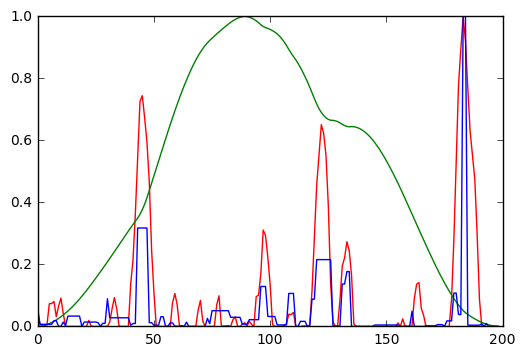

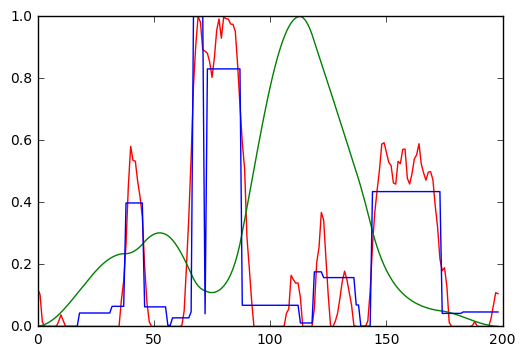

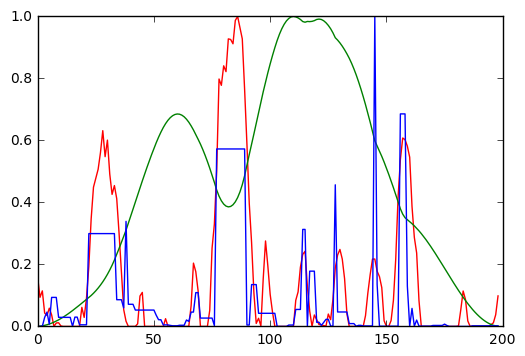

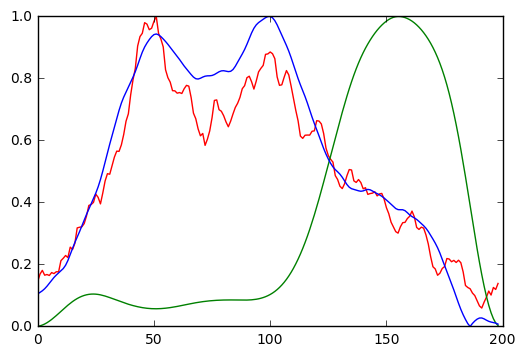

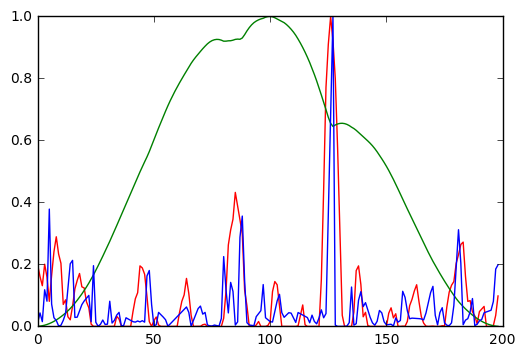

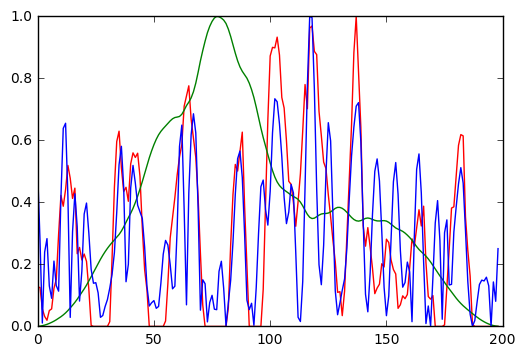

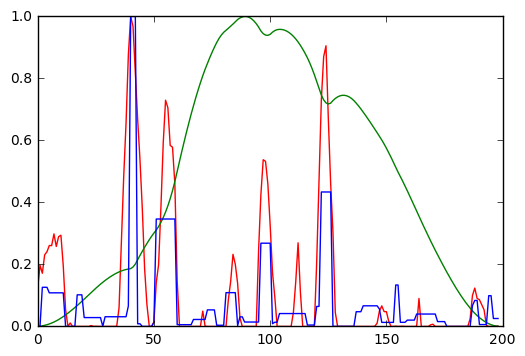

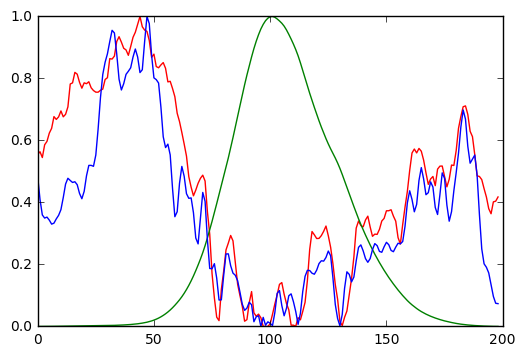

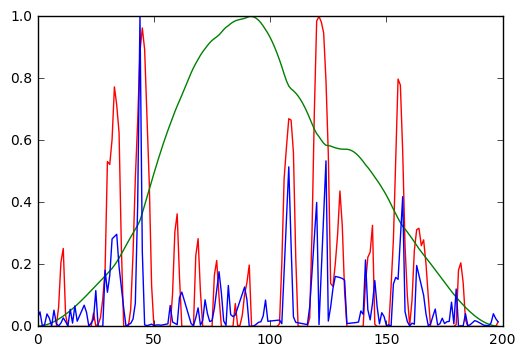

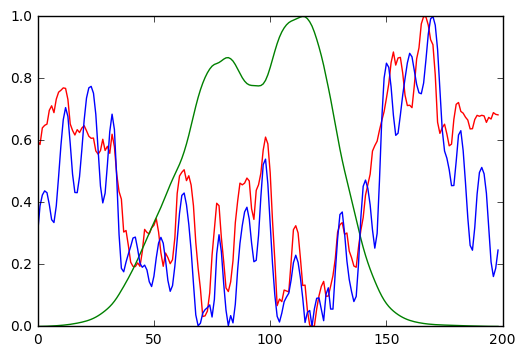

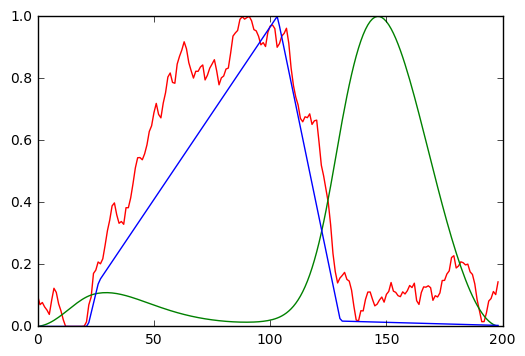

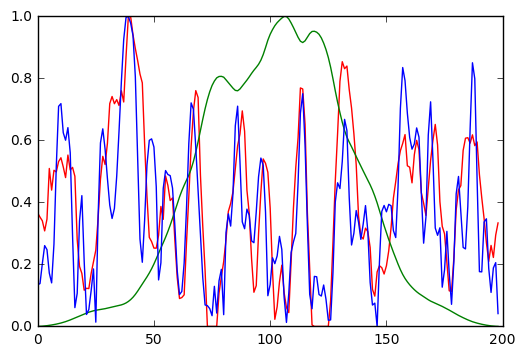

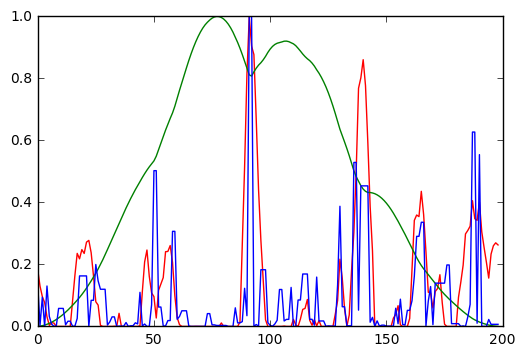

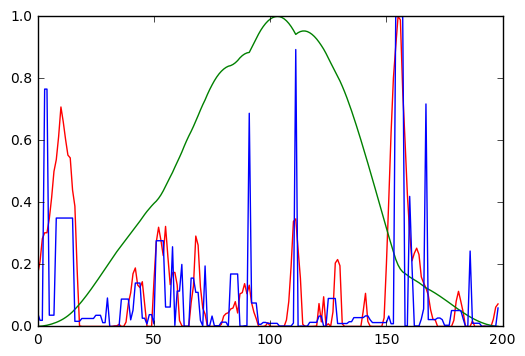

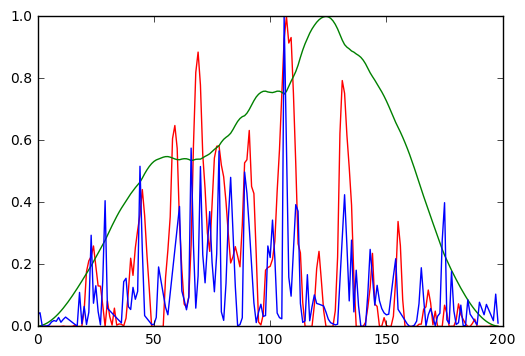

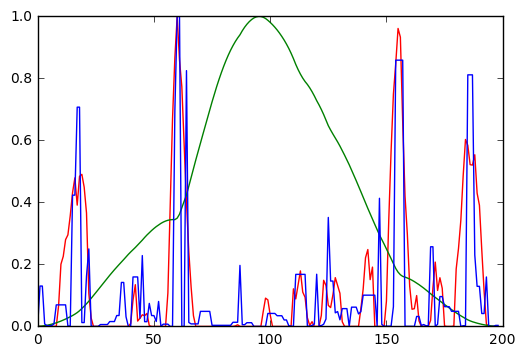

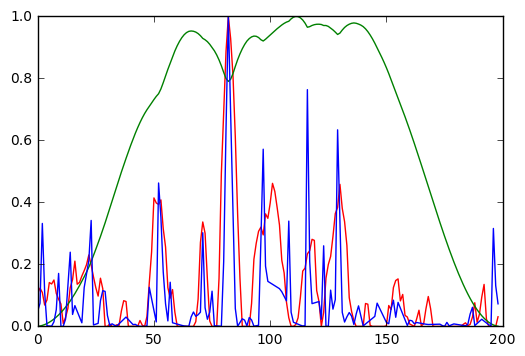

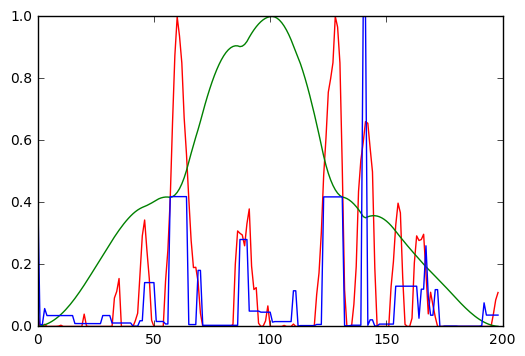

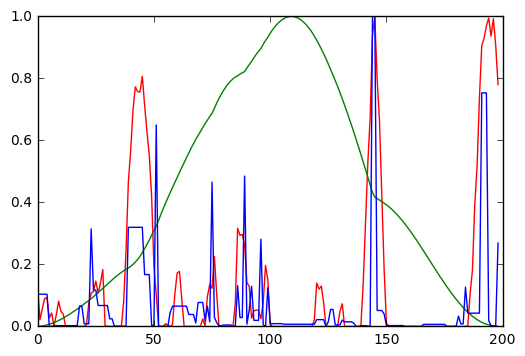

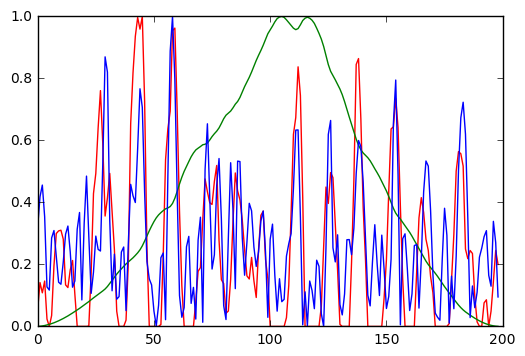

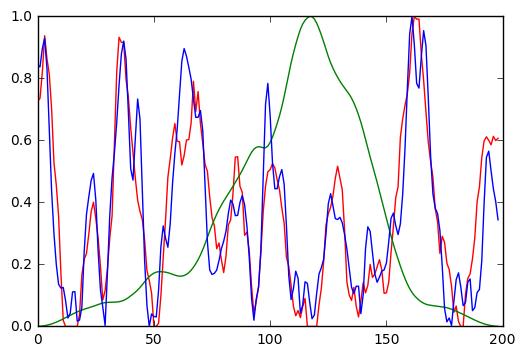

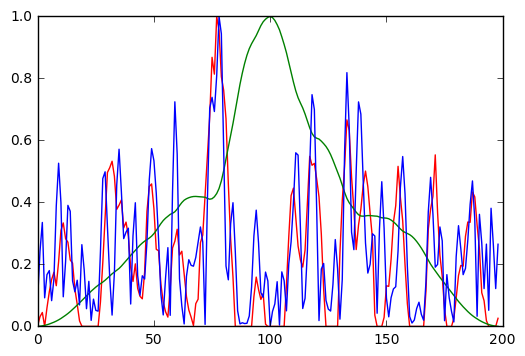

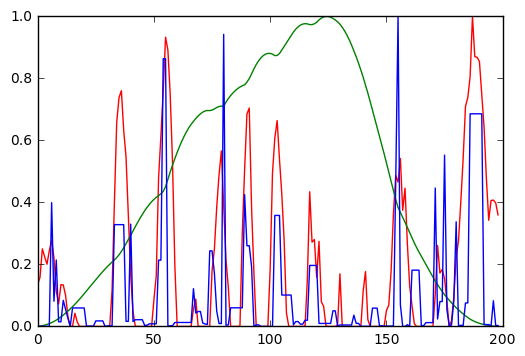

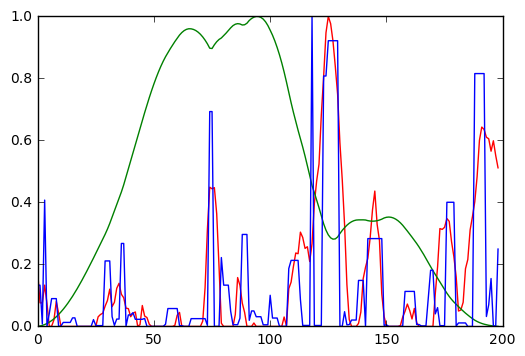

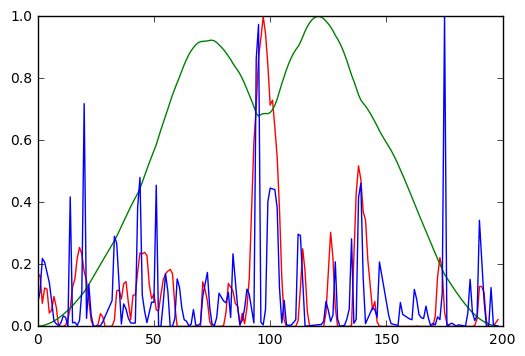

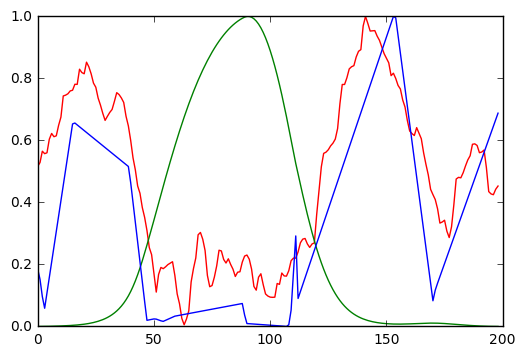

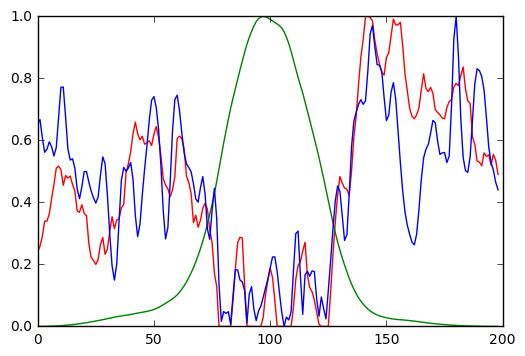

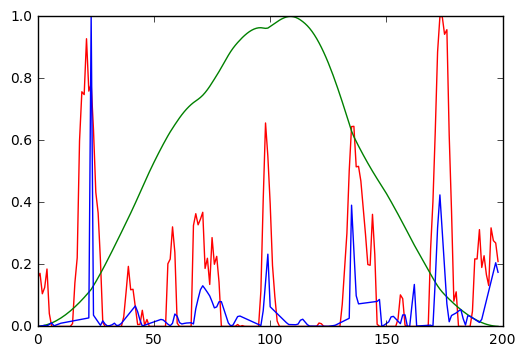

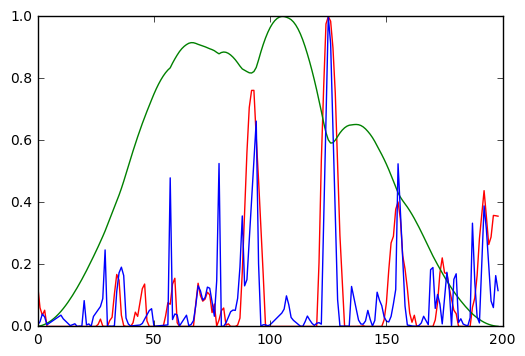

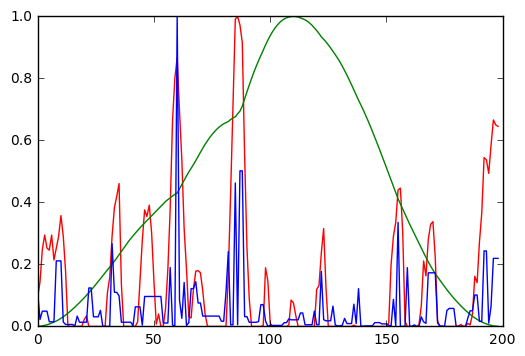

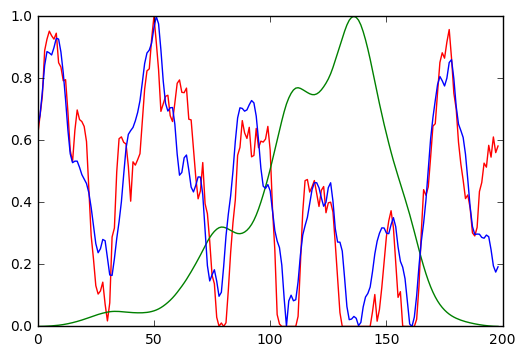

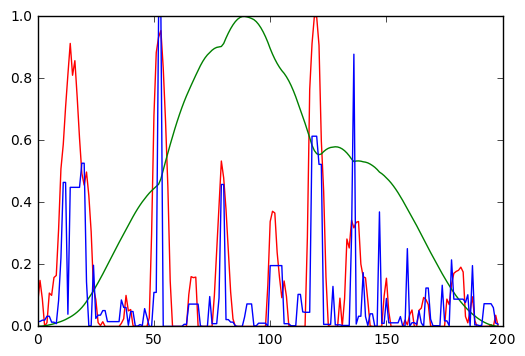

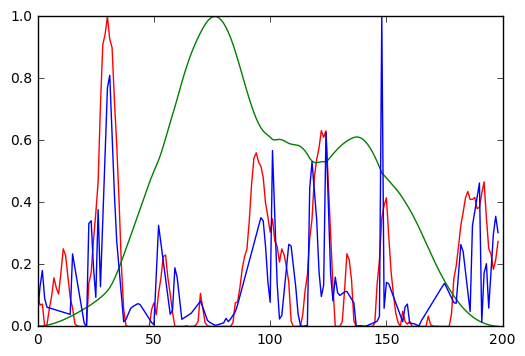

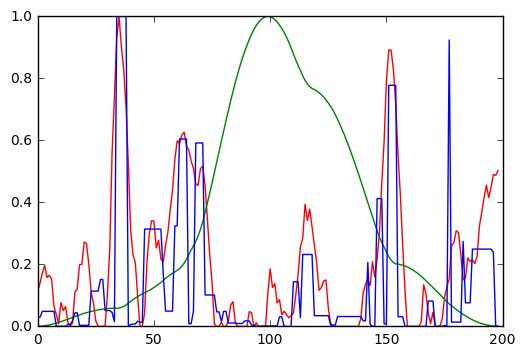

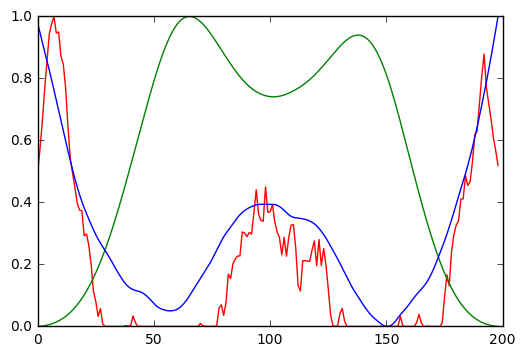

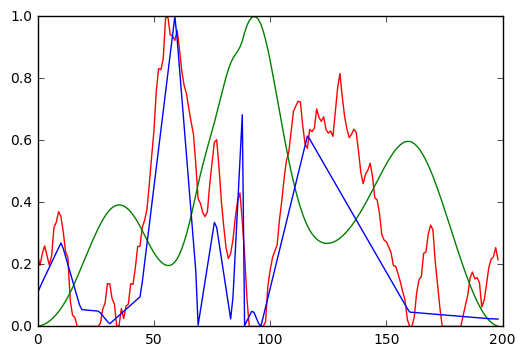

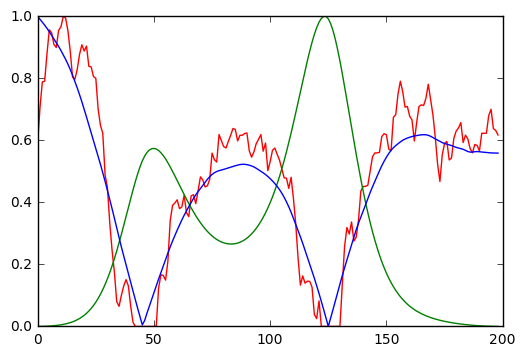

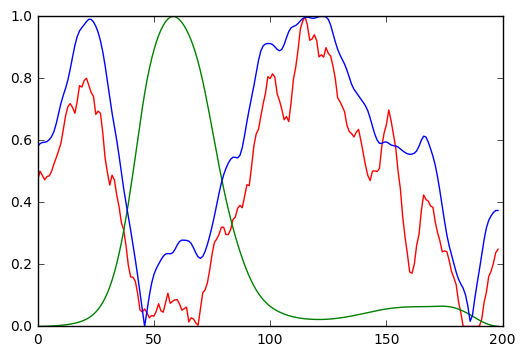

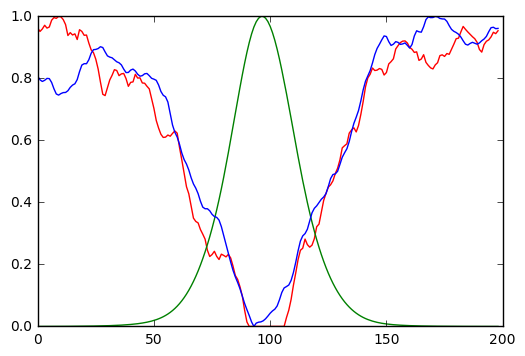

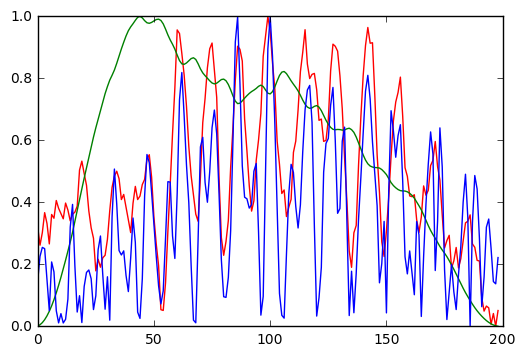

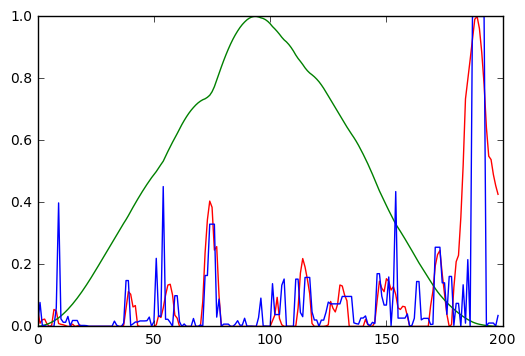

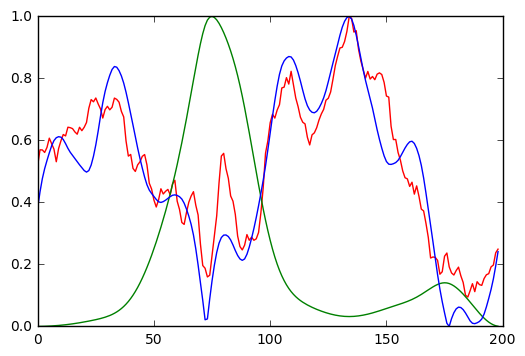

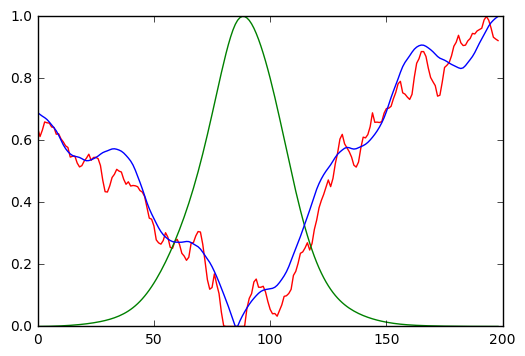

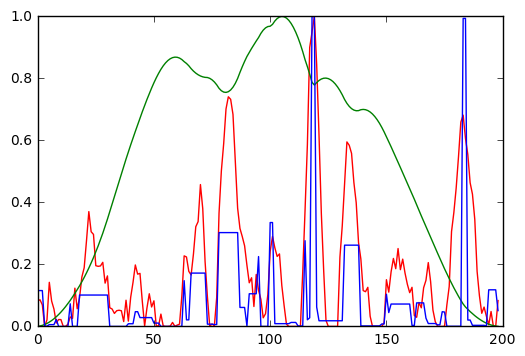

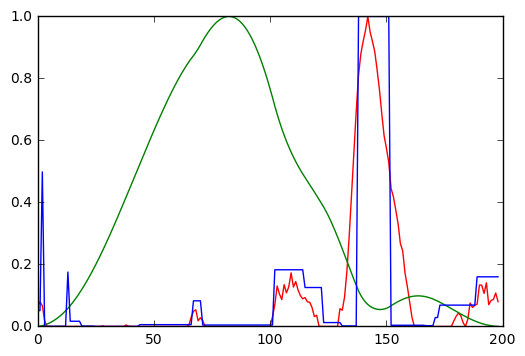

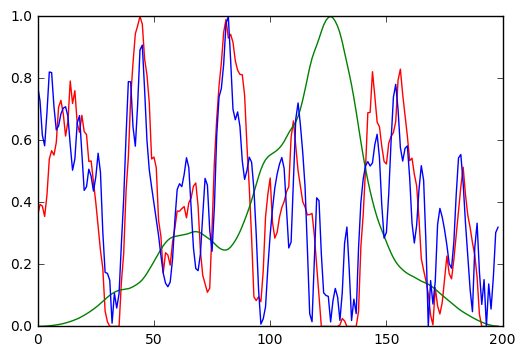

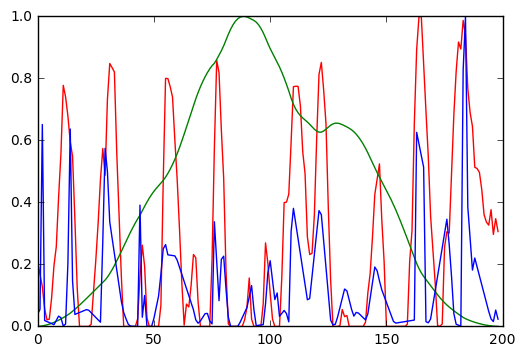

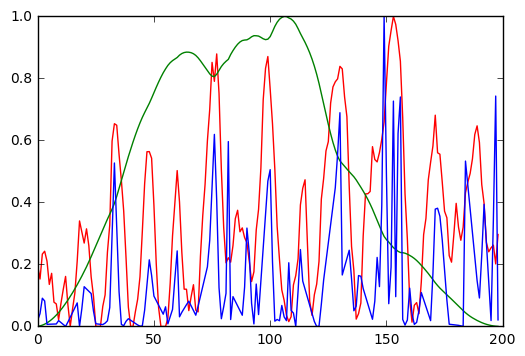

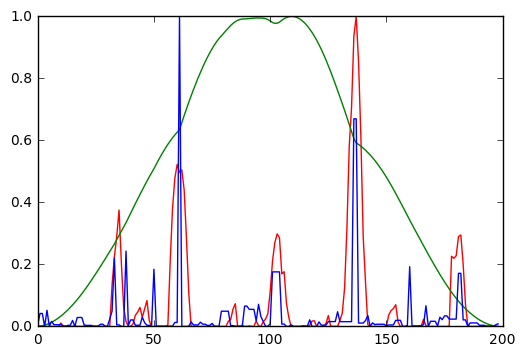

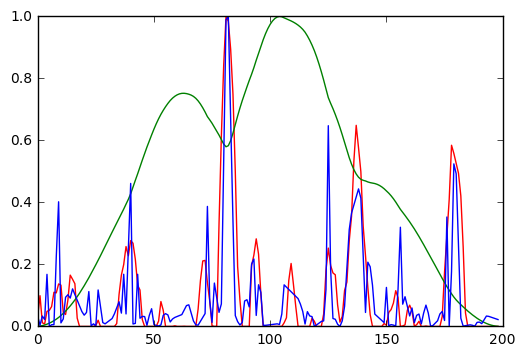

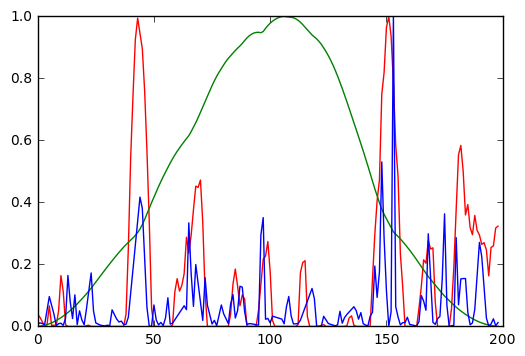

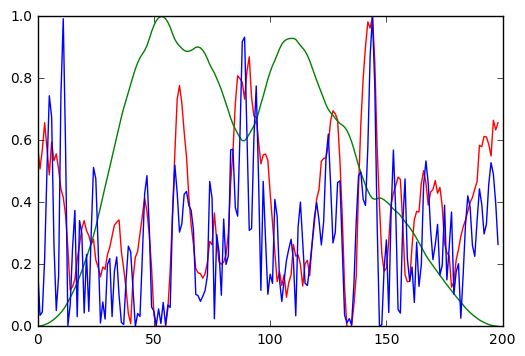

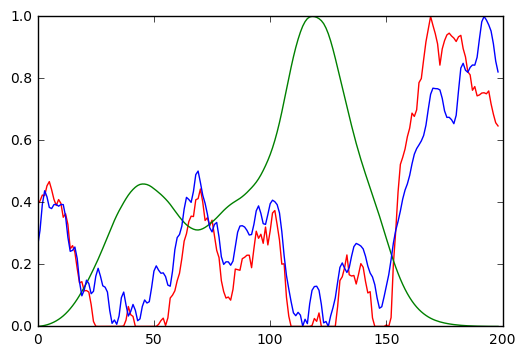

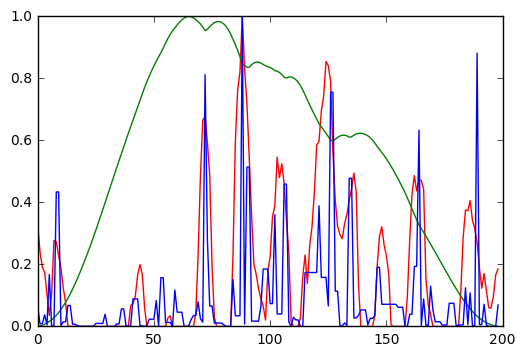

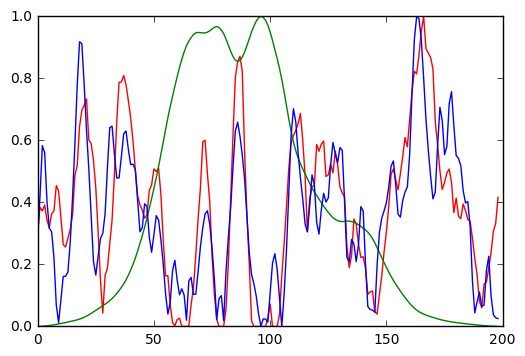

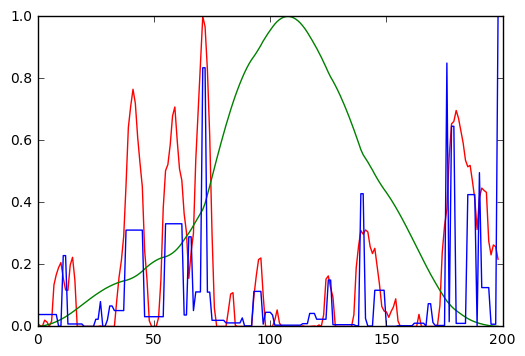

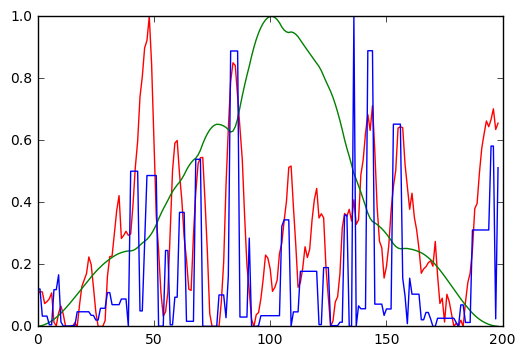

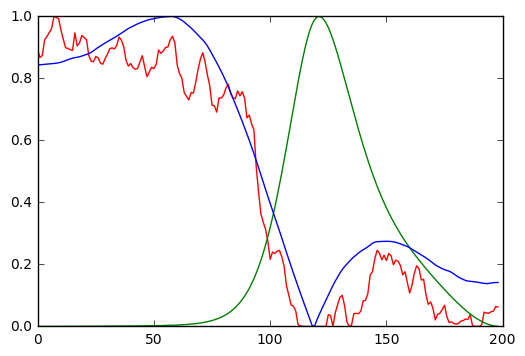

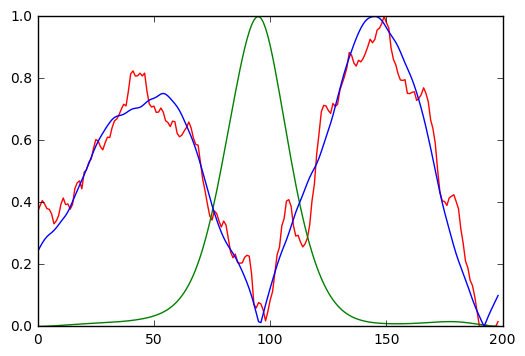

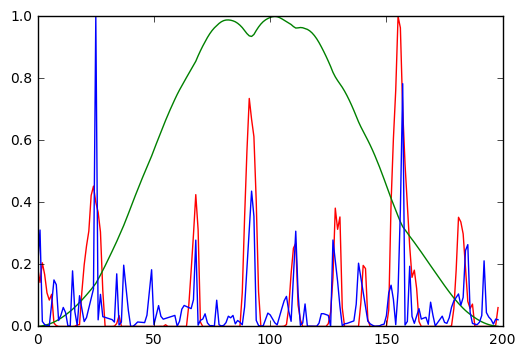

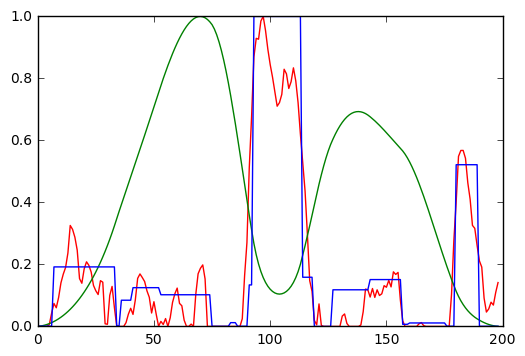

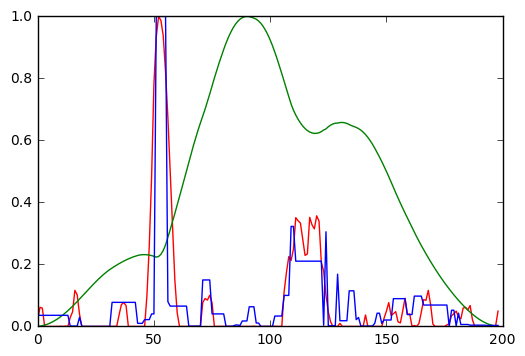

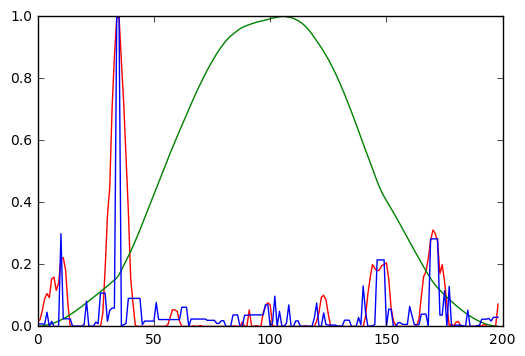

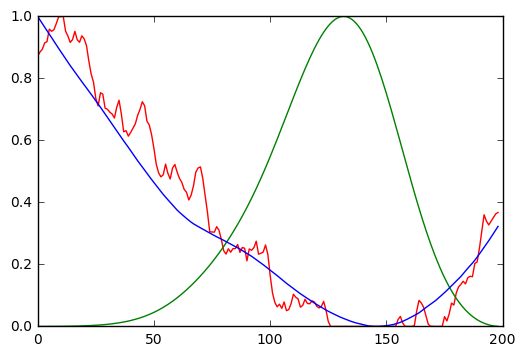

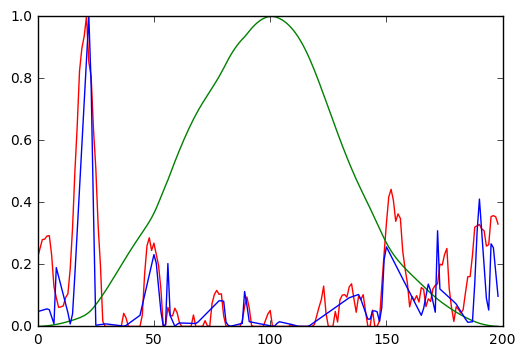

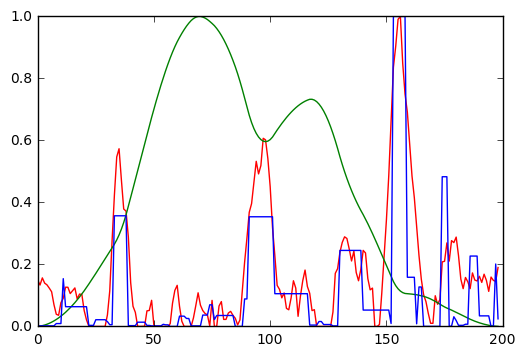

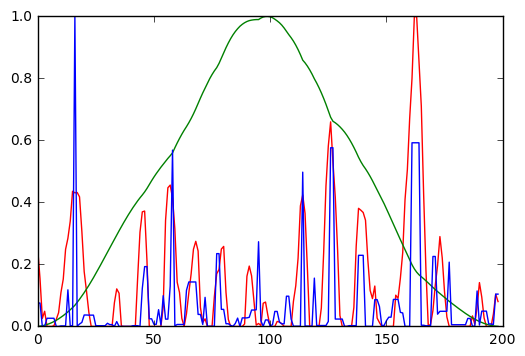

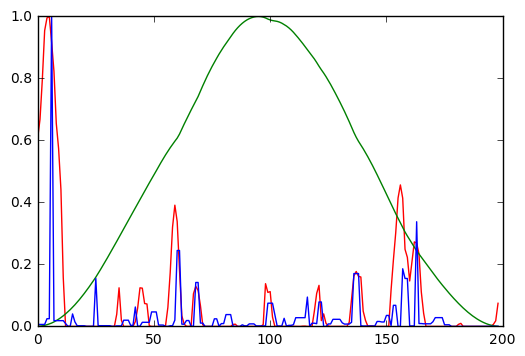

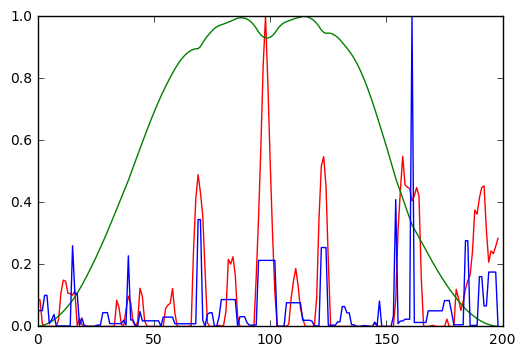

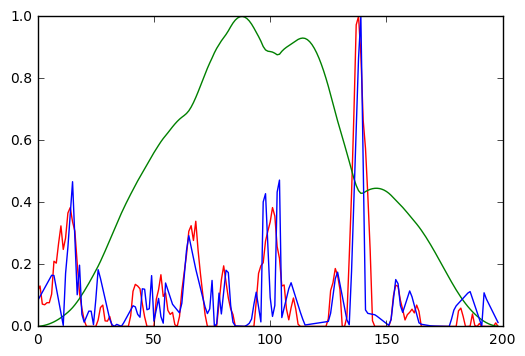

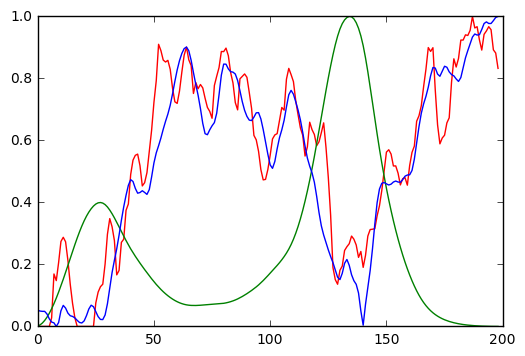

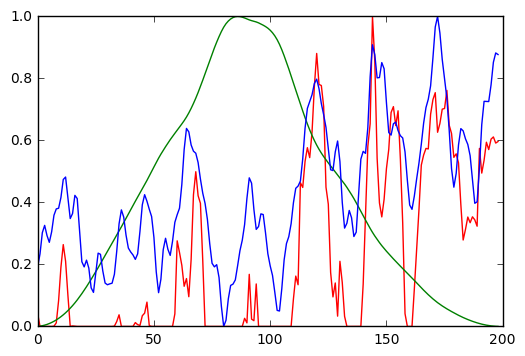

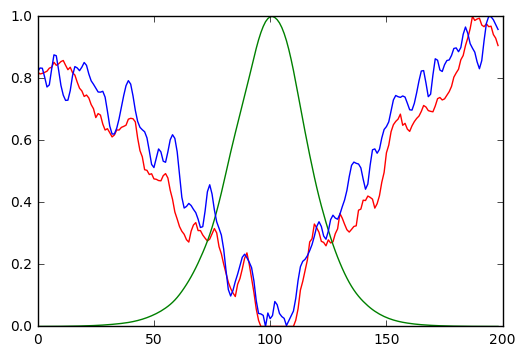

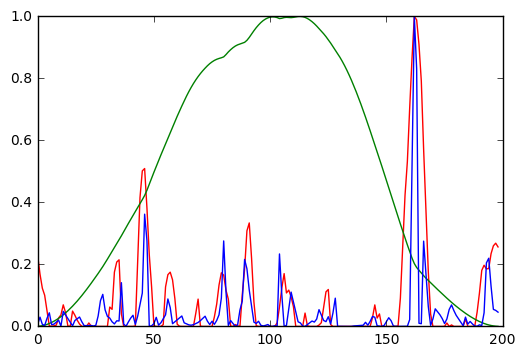

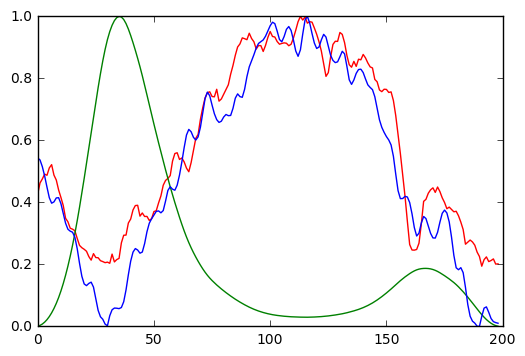

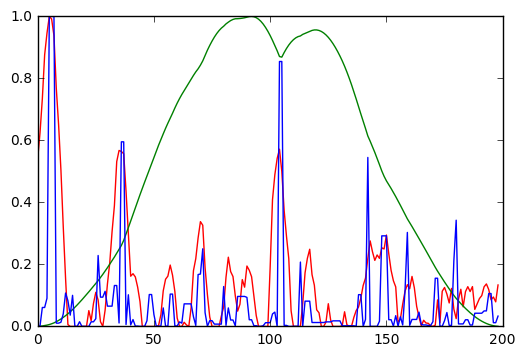

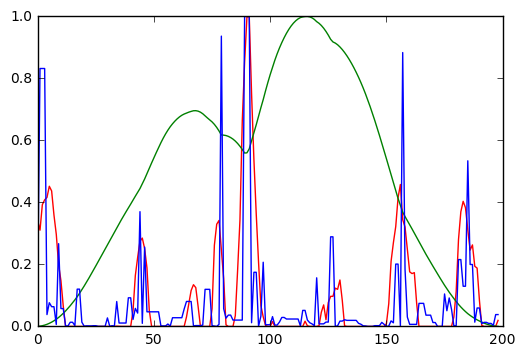

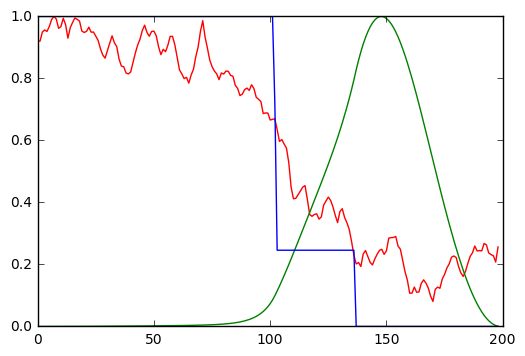

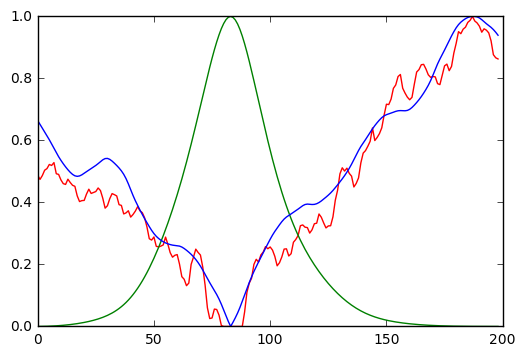

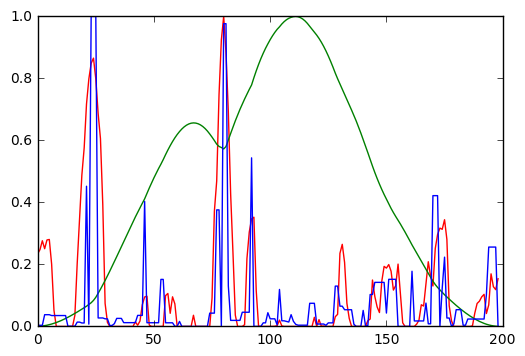

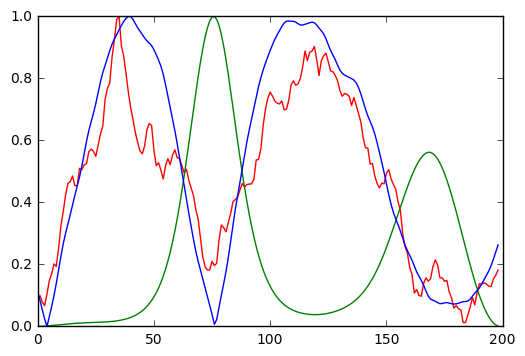

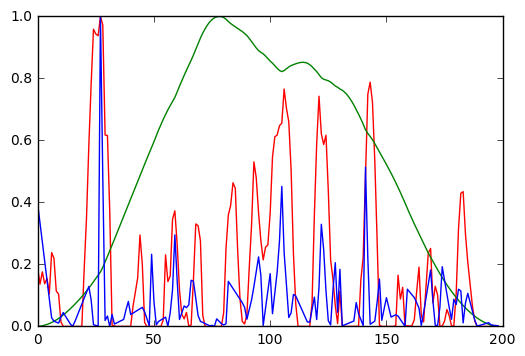

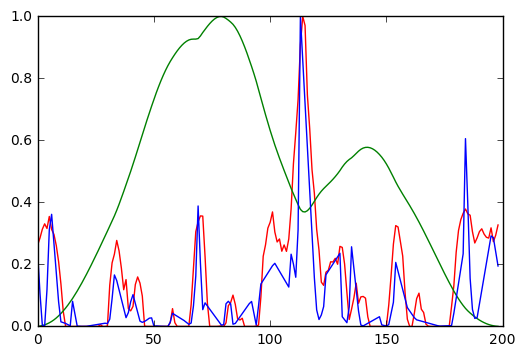

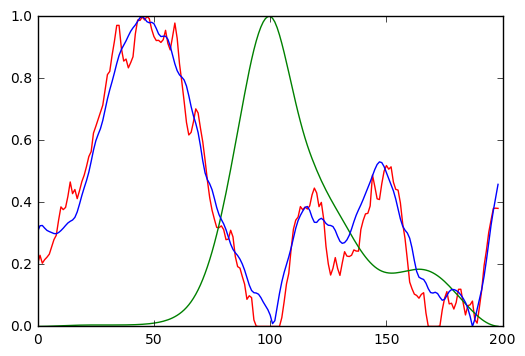

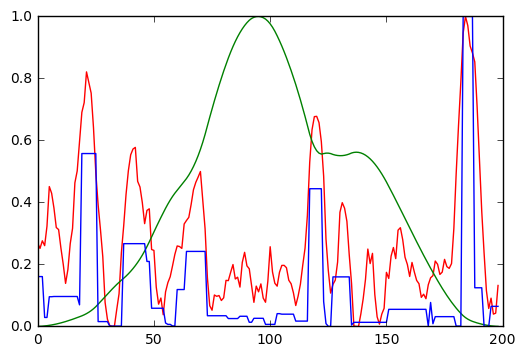

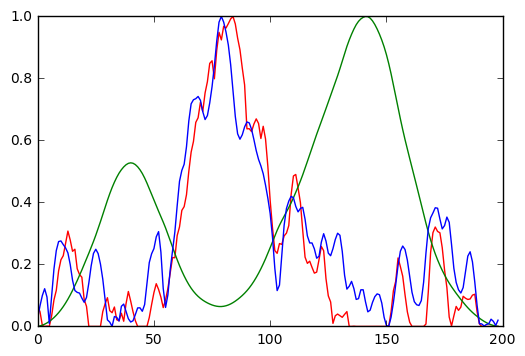

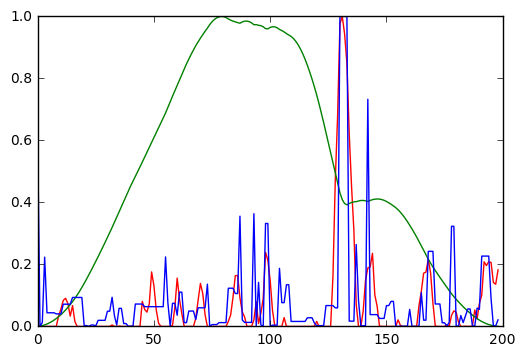

In [42]:
'''초록색은 프사이값, 파란색은 정답, 빨간색은 예측 값이다.'''
val_psi = psi_v[train_set:]
result_poten_v = sess.run(result_poten, feed_dict={X_input:val_psi[:100,:], tfph_BNbool:False})
print(result_poten_v.shape)
for i in range (100):
    plt.plot(result_poten_v[i]/max(result_poten_v[i]),'-r')
    plt.plot(val_psi[i]/max(val_psi[i]),'-g')
    plt.plot(val_poten[i]/max(val_poten[i]),'-b')    
    plt.show()